# Reduction-based Forecasting with scikit-learn Regressors in sktime

This tutorial demonstrates how traditional machine learning regressors from **scikit-learn** can be used for time series forecasting through **reduction techniques** in `sktime`.

Reduction transforms a forecasting problem into a supervised regression task by converting past observations into tabular features.

---

## Learning Objectives

By the end of this tutorial you will:

- Understand reduction-based forecasting  
- Learn the difference between **recursive** and **direct** strategies  
- Convert time series into tabular features  
- Use **WindowSummarizer** for feature engineering  
- Build forecasting pipelines with **Differencer**  
- Apply sklearn regressors to time series prediction  


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sktime.datasets import load_airline
from sktime.split import temporal_train_test_split
from sktime.utils.plotting import plot_series

from sktime.forecasting.compose import make_reduction
from sktime.forecasting.compose import ForecastingPipeline
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.summarize import WindowSummarizer


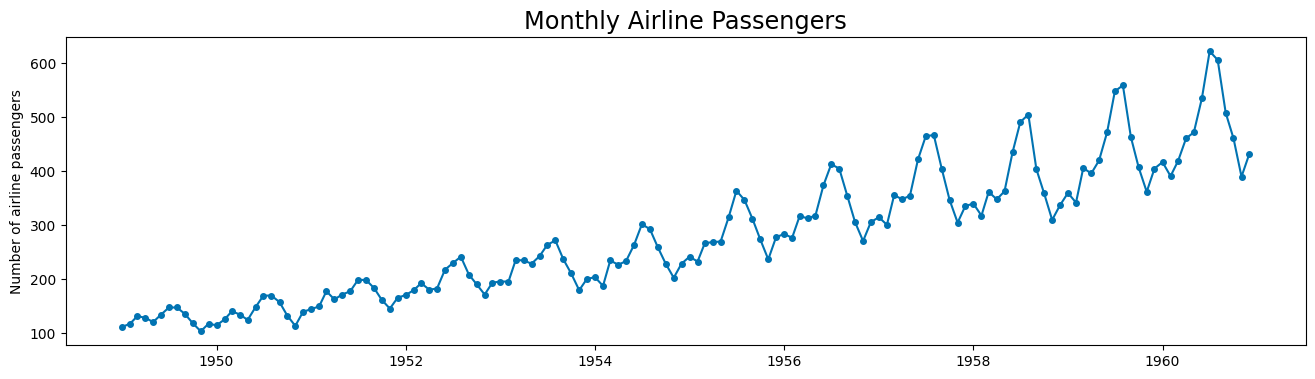

In [2]:
y = load_airline()

plot_series(y, title="Monthly Airline Passengers")
plt.show()


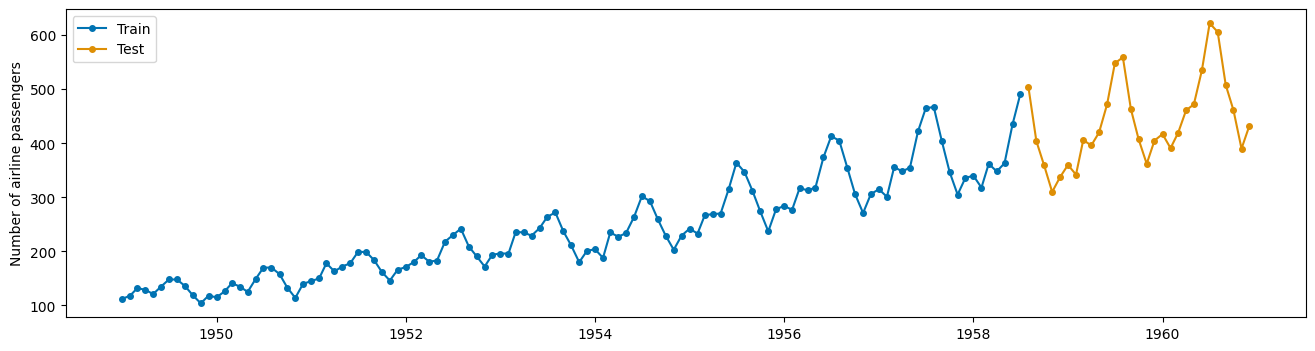

In [3]:
y_train, y_test = temporal_train_test_split(y, test_size=0.2)

plot_series(y_train, y_test, labels=["Train", "Test"])
plt.show()


## What are Reduction Forecasters?

Reduction is a strategy that converts a time series forecasting problem into a supervised machine learning task.

Instead of modeling temporal structure directly, past observations are transformed into tabular features which can be used by standard regressors such as those from sklearn.

Each sliding window becomes one training sample where previous observations are used as features and the next value becomes the prediction target.


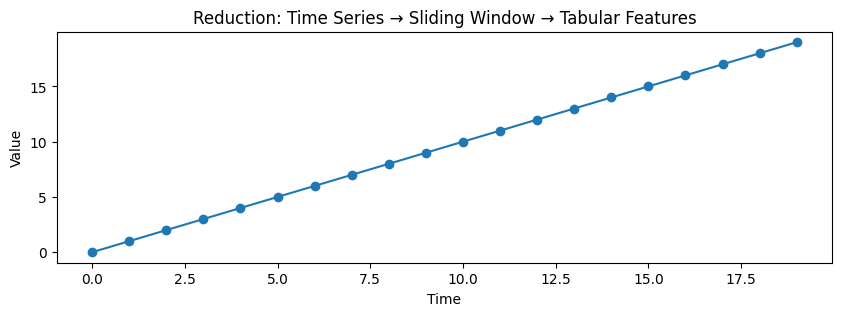

In [4]:
series = np.arange(20)

plt.figure(figsize=(10,3))
plt.plot(series, marker='o')
plt.title("Reduction: Time Series → Sliding Window → Tabular Features")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()


## Recursive Forecasting Strategy

The recursive strategy trains **one model** and generates forecasts step-by-step.

Each prediction is fed back into the model to predict the next timestep.  
While computationally efficient, errors may accumulate for longer horizons.


In [5]:
fh = list(range(1, 13))

recursive_forecaster = make_reduction(
    RandomForestRegressor(random_state=42),
    strategy="recursive",
    window_length=12
)

recursive_forecaster.fit(y_train)
recursive_pred = recursive_forecaster.predict(fh)


## Direct Forecasting Strategy

The direct strategy trains a **separate model for each forecast horizon**.

This approach is typically more stable for long-range forecasts since prediction errors do not propagate forward, but it requires more computational effort.


In [6]:
direct_forecaster = make_reduction(
    RandomForestRegressor(random_state=42),
    strategy="direct",
    window_length=12
)

direct_forecaster.fit(y_train, fh=fh)
direct_pred = direct_forecaster.predict(fh)


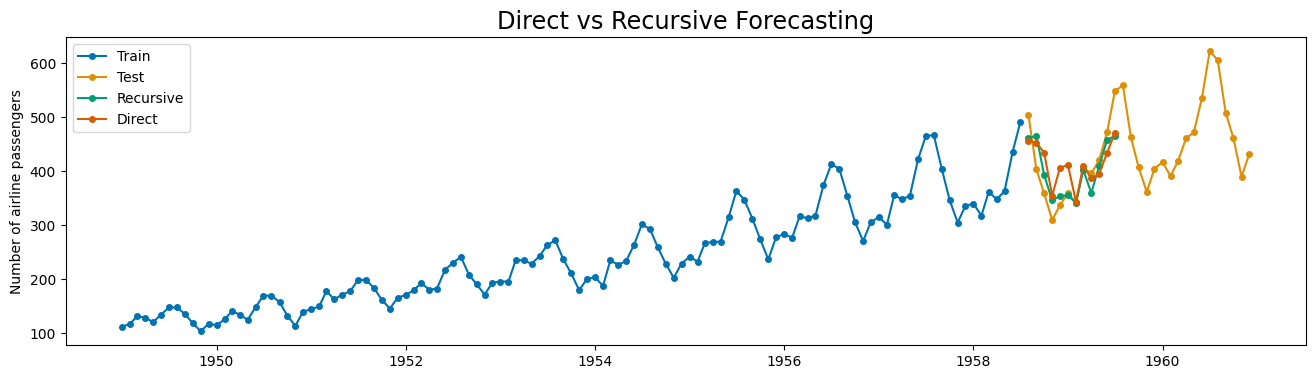

In [7]:
plot_series(
    y_train,
    y_test,
    recursive_pred,
    direct_pred,
    labels=["Train", "Test", "Recursive", "Direct"],
    title="Direct vs Recursive Forecasting"
)
plt.show()


## Creating Tabular Features with WindowSummarizer

`WindowSummarizer` converts time series into tabular features such as lags and rolling statistics.

These engineered features allow machine learning models to better capture temporal structure.


In [8]:
summarizer = WindowSummarizer(
    lag_feature={
        "lag": [1,2,3],
        "mean": [[1,3]]
    }
)

X_features = summarizer.fit_transform(y_train)
X_features.head()


,Number of airline passengers_lag_1,Number of airline passengers_lag_2,Number of airline passengers_lag_3,Number of airline passengers_mean_1_3
1949-01,NaN,NaN,NaN,NaN
1949-02,112.0,NaN,NaN,NaN
1949-03,118.0,112.0,NaN,NaN
1949-04,132.0,118.0,112.0,120.666667
1949-05,129.0,132.0,118.0,126.333333


## Using sklearn Pipelines inside Reduction

Because reduction relies on sklearn regressors, preprocessing steps such as scaling can be integrated seamlessly.


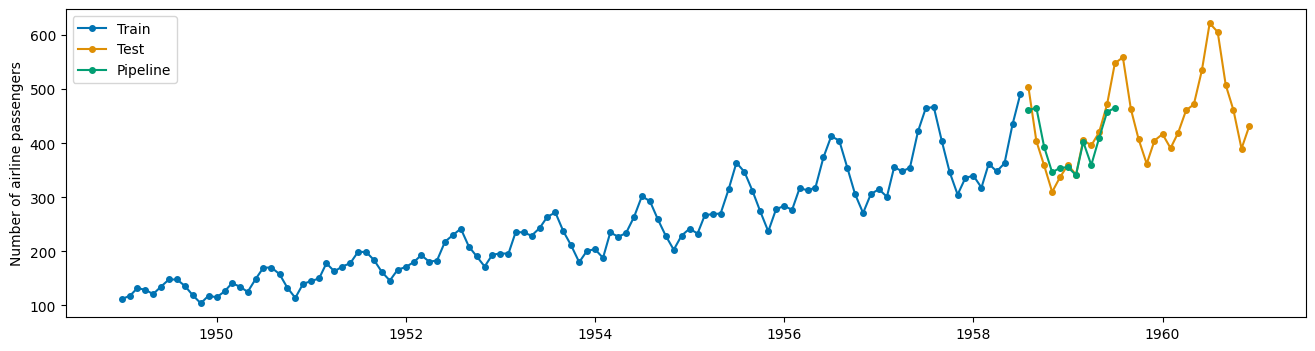

In [9]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestRegressor(random_state=42))
])

pipeline_forecaster = make_reduction(
    pipeline,
    strategy="recursive",
    window_length=12
)

pipeline_forecaster.fit(y_train)
pipeline_pred = pipeline_forecaster.predict(fh)

plot_series(y_train, y_test, pipeline_pred, labels=["Train", "Test", "Pipeline"])
plt.show()


## Using sktime Pipelines with Differencer

Differencing is especially useful when the time series shows trend, as many machine learning regressors assume stationary data.

`sktime` pipelines allow transformations to be applied before forecasting.


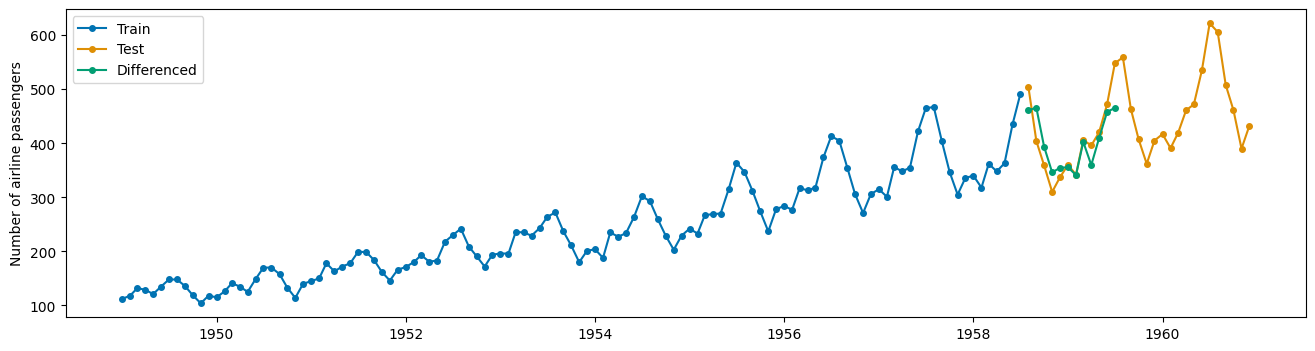

In [10]:
diff_pipeline = ForecastingPipeline(steps=[
    ("differencer", Differencer()),
    ("forecaster", make_reduction(
        RandomForestRegressor(random_state=42),
        strategy="recursive",
        window_length=12
    ))
])

diff_pipeline.fit(y_train)
diff_pred = diff_pipeline.predict(fh)

plot_series(y_train, y_test, diff_pred, labels=["Train", "Test", "Differenced"])
plt.show()


## Key Takeaways

- Reduction enables scikit-learn regressors to solve forecasting tasks  
- Recursive and direct strategies offer different trade-offs  
- WindowSummarizer helps transform time series into informative tabular features  
- Differencing can improve performance when trends are present  
- sktime pipelines integrate seamlessly with machine learning workflows  

Reduction provides a flexible and powerful approach for machine learning-based forecasting.
